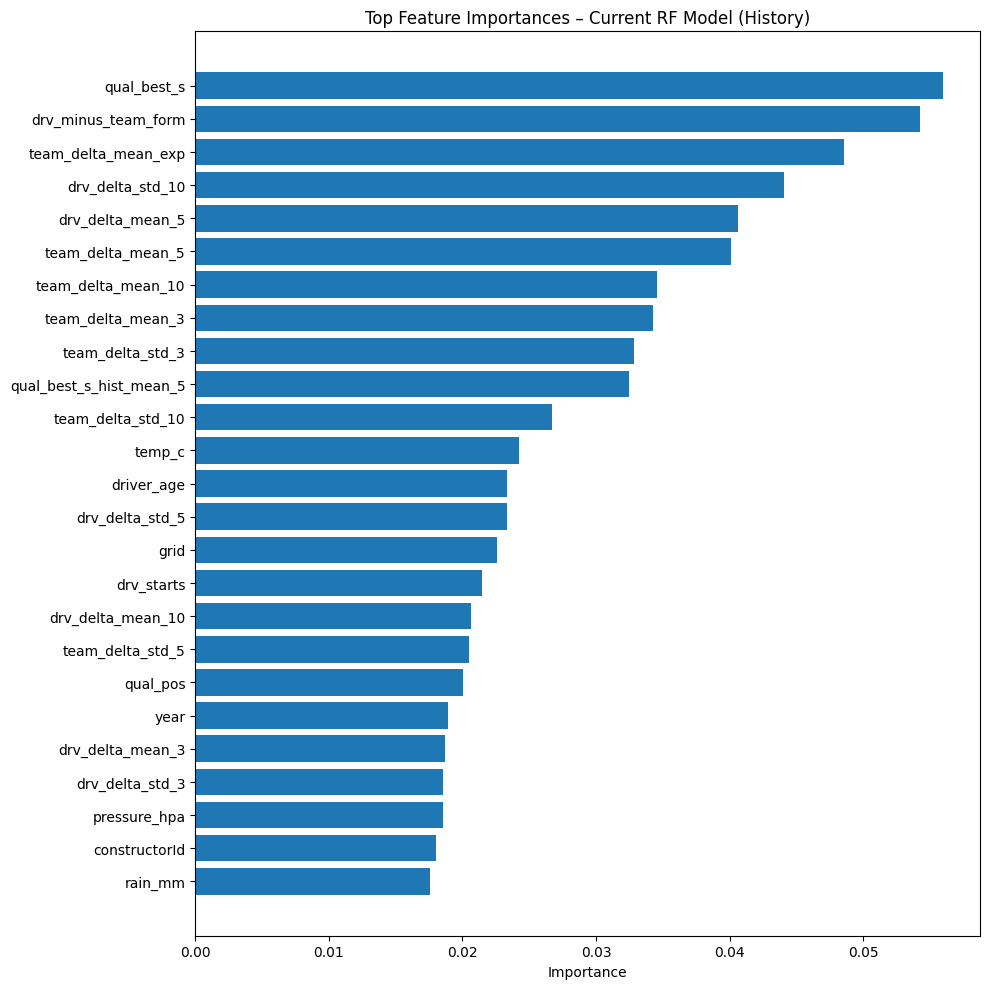

In [2]:
# === Cell: Load model and plot feature importances ===
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer


# Resolve project ROOT whether you're in the repo root or in notebooks/
NB_DIR = Path.cwd()
ROOT = NB_DIR if (NB_DIR / "models").exists() else NB_DIR.parent

# Pick the model you want to visualize
MODEL_NAME = "rf_model_delta_hist_v1.joblib"   # <-- change if you want a different file
MODEL_PATH = ROOT / "models" / MODEL_NAME

assert MODEL_PATH.exists(), f"Model not found at {MODEL_PATH}"
pipe = joblib.load(MODEL_PATH)

# Try to locate the preprocess and model steps robustly
steps = dict(pipe.named_steps)
pre_key = [k for k in steps if "pre" in k][0]       # e.g., 'preprocess'
model_key = [k for k in steps if k != pre_key][0]   # e.g., 'rf'
preprocess = steps[pre_key]
model = steps[model_key]

# Rebuild the feature names from the ColumnTransformer
def get_feature_names_from_ct(ct: "ColumnTransformer") -> list[str]:
    names = []
    for name, transformer, columns in ct.transformers_:
        if name == "remainder" and transformer == "drop":
            continue
        if hasattr(transformer, "get_feature_names_out"):
            # OneHotEncoder, etc.
            fn = transformer.get_feature_names_out(columns)
            names.extend(fn.tolist())
        elif transformer == "passthrough":
            # passthrough numeric
            if isinstance(columns, (list, tuple)):
                names.extend(list(columns))
            else:
                names.append(columns)
        else:
            # Pipeline inside ColumnTransformer
            if hasattr(transformer, "named_steps"):
                last = list(transformer.named_steps.values())[-1]
                if hasattr(last, "get_feature_names_out"):
                    fn = last.get_feature_names_out(columns)
                    names.extend(fn.tolist())
                else:
                    names.extend(list(columns))
            else:
                names.extend(list(columns))
    return names

feature_names = get_feature_names_from_ct(preprocess)
importances = getattr(model, "feature_importances_", None)
assert importances is not None, "This model doesn't expose feature_importances_."

# Plot top-k
k = 25
order = np.argsort(importances)[::-1][:k]
plt.figure(figsize=(10, 10))
plt.barh(np.array(feature_names)[order][::-1], importances[order][::-1])
plt.title("Top Feature Importances – Current RF Model (History)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


✅ Saved CSV -> ..\outputs\feature_importance_hist_v1.csv


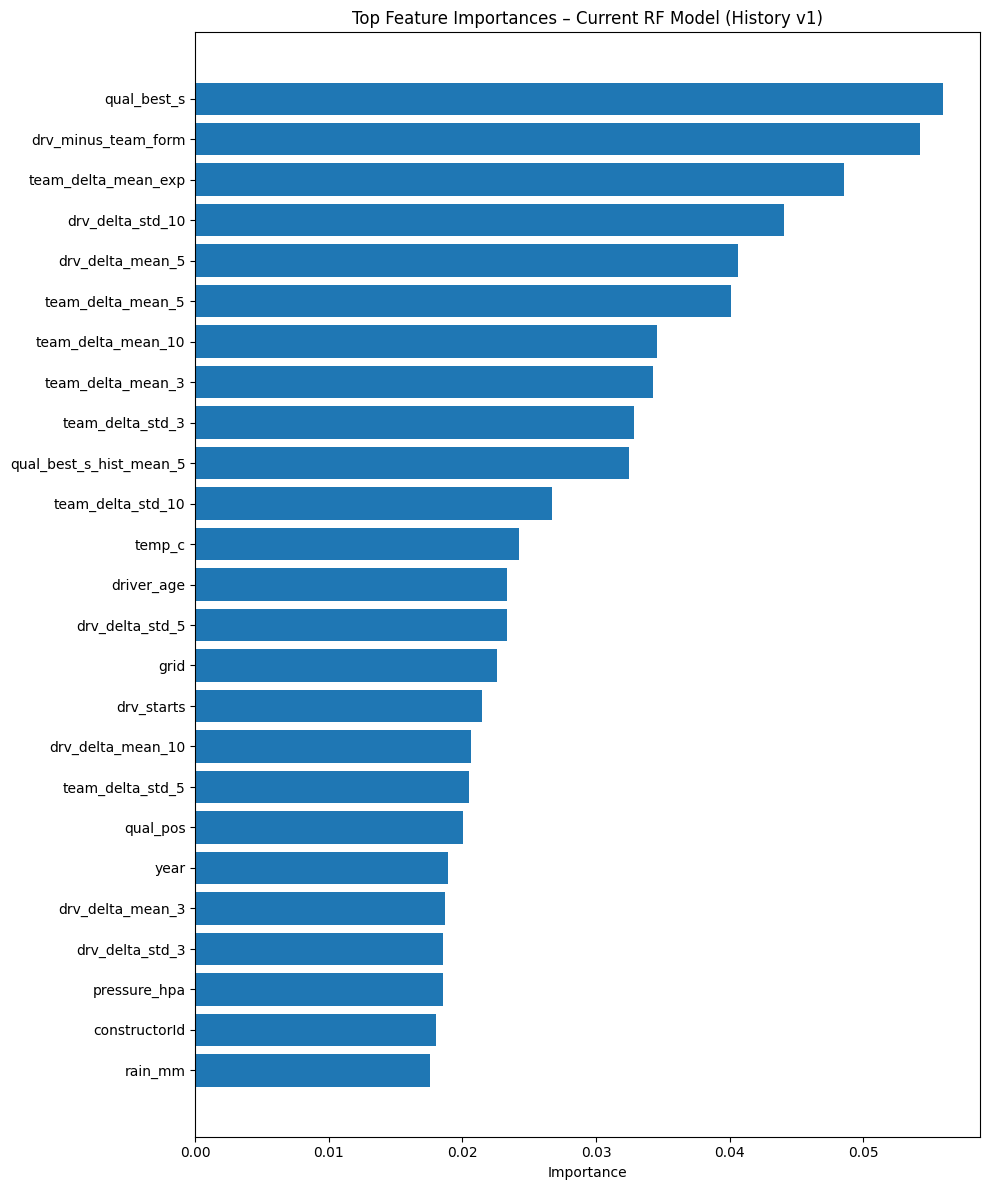

✅ Saved PNG -> ..\outputs\feature_importance_hist_v1.png


In [4]:
# === Export Feature Importance Plot + CSV ===

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Where to save exports
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

PNG_PATH = OUT_DIR / "feature_importance_hist_v1.png"
CSV_PATH = OUT_DIR / "feature_importance_hist_v1.csv"

# Ensure feature_names is numpy array for indexed selection
feature_names_np = np.array(feature_names)

# Select top-k sorted features (& importance)
top_features = feature_names_np[order[::-1]][:k]
top_importances = importances[order[::-1]][:k]

# Create DataFrame
feat_df = pd.DataFrame({"feature": top_features, "importance": top_importances})
feat_df.to_csv(CSV_PATH, index=False)
print(f"✅ Saved CSV -> {CSV_PATH}")

# Recreate plot & save PNG
plt.figure(figsize=(10, 12))
plt.barh(top_features, top_importances)
plt.title("Top Feature Importances – Current RF Model (History v1)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(PNG_PATH, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved PNG -> {PNG_PATH}")
